In [1]:
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

2024-03-26 14:48:53.899529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 14:48:53.899624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 14:48:54.058303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'/device:GPU:0'

In [2]:

!pip install split-folders

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
base_ds = '/kaggle/input/tea-leaf-disease/Tea_Leaf_Disease'
base_ds = pathlib.Path(base_ds)
splitfolders.ratio(base_ds, output='Tea Leaf Dataset', seed=123, ratio=(.8,.2), group_prefix=None)

Copying files: 6006 files [00:41, 145.88 files/s]


In [7]:
algal_spot = [fn for fn in os.listdir(f'{base_ds}/algal_spot') if fn.endswith('.jpg')]
brown_blight = [fn for fn in os.listdir(f'{base_ds}/brown_blight') if fn.endswith('.jpg')]
gray_blight = [fn for fn in os.listdir(f'{base_ds}/gray_blight') if fn.endswith('.jpg')]
healthy = [fn for fn in os.listdir(f'{base_ds}/healthy') if fn.endswith('.jpg')]
helopeltis = [fn for fn in os.listdir(f'{base_ds}/helopeltis') if fn.endswith('.jpg')]
red_spot= [fn for fn in os.listdir(f'{base_ds}/red_spot') if fn.endswith('.jpg')]
tea = [algal_spot, brown_blight, gray_blight, healthy,helopeltis,red_spot]
tea_classes = []
for i in os.listdir('/kaggle/working/Tea Leaf Dataset/train'):
    tea_classes+=[i]
tea_classes.sort()

In [8]:
train_data = "/kaggle/working/Tea Leaf Dataset/train"
test_data = "/kaggle/working/Tea Leaf Dataset/val"

In [9]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in tea_classes:
    i+=1
    plt.subplot(1, 7, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

In [10]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [11]:
# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(

    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.2,
    horizontal_flip=True,
    #vertical_flip = True,
    rescale=1./255,
     )

train_ds = datagen.flow_from_directory(
    '/kaggle/working/Tea Leaf Dataset/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

test_ds = datagen.flow_from_directory(
    '/kaggle/working/Tea Leaf Dataset/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)


Found 4804 images belonging to 6 classes.
Found 1202 images belonging to 6 classes.


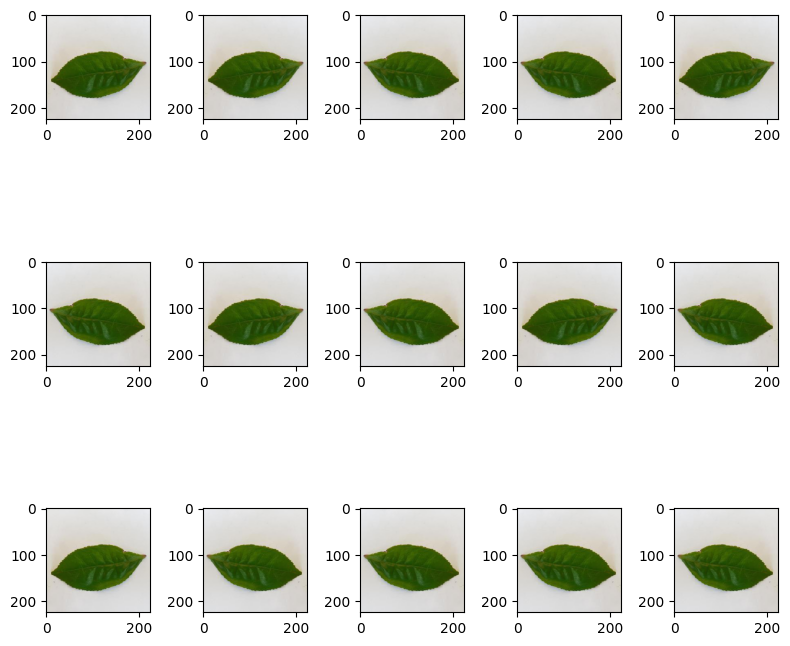

In [12]:
#Check Sample Image after augmentation
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
      #  plt.grid(None)
    plt.tight_layout()
    plt.show()


augmented_images = [train_ds[0][0][0] for i in range(16)]
plotImages(augmented_images)

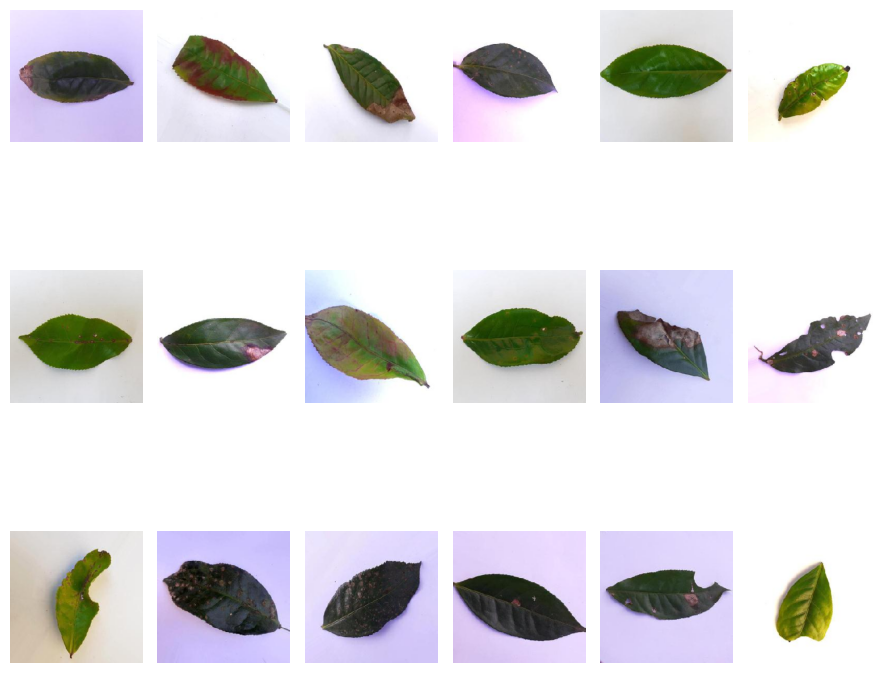

In [14]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(3, 6, figsize=(9, 9))
    for img, ax in zip(images_arr, axes.flatten()):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of augmented images from the training dataset
augmented_images, _ = train_ds.next()

# Plot augmented images
sample_images = augmented_images[:18]  # Select the first 15 augmented images
plotImages(sample_images)


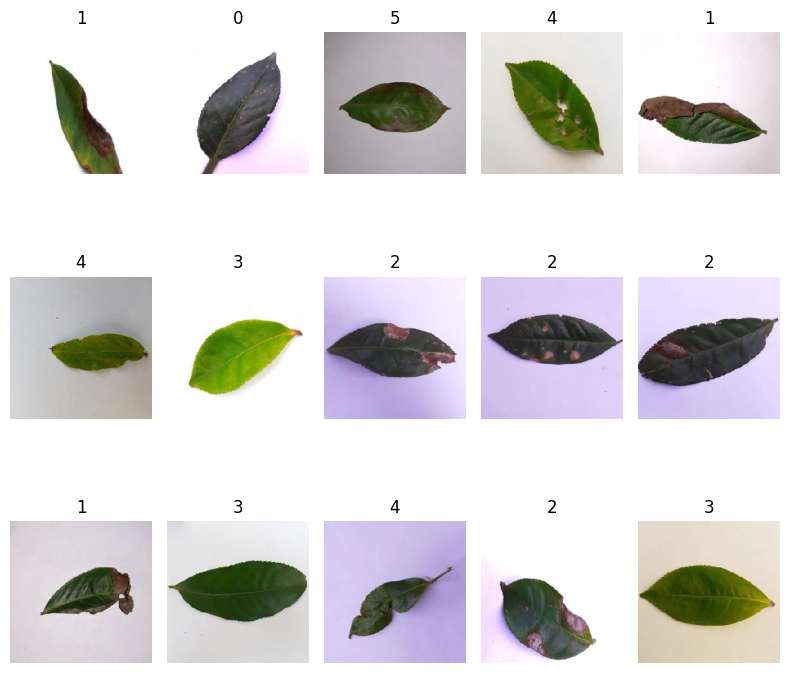

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(3, 5, figsize=(8, 8))
    for img, label, ax in zip(images_arr, labels_arr, axes.flatten()):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

# Get a batch of augmented images and labels from the training dataset
augmented_images, augmented_labels = train_ds.next()

# Convert one-hot encoded labels to class labels
class_labels = np.argmax(augmented_labels, axis=1)

# Plot augmented images with labels
sample_images = augmented_images[:15]  # Select the first 15 augmented images
sample_labels = class_labels[:15]  # Select the corresponding labels
plotImages(sample_images, sample_labels)

****VGG16***


In [15]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(224,224,3),
    pooling='max')
base_model.trainable = False # Freeze the base_model
# Let's take a look at the base model architecture
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
model_vgg16 = Sequential()
model_vgg16.add(base_model)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dense(6, activation='sigmoid'))
model_vgg16.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14980422 (57.15 MB)
Trainable params: 265734 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
history2 = model_vgg16.fit(train_ds, epochs = 50, validation_data = test_ds, steps_per_epoch=5)#, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1711382248.390645     150 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 22s 3s/step - loss: 1.9832 - accuracy: 0.2000 - val_loss: 1.9731 - val_accuracy: 0.1730
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 1.7329 - accuracy: 0.2812 - val_loss: 1.6324 - val_accuracy: 0.2887
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 1.5817 - accuracy: 0.3125 - val_loss: 1.3851 - val_accuracy: 0.4875
Epoch 4/50
5/5 [==============================] - 5s 1s/step - loss: 1.3065 - accuracy: 0.4875 - val_loss: 1.3501 - val_accuracy: 0.4975
Epoch 5/50
5/5 [==============================] - 5s 1s/step - loss: 1.3284 - accuracy: 0.4563 - val_loss: 1.3306 - val_accuracy: 0.4418
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 1.2364 - accuracy: 0.4688 - val_loss: 1.1462 - val_accuracy: 0.6065
Epoch 7/50
5/5 [==============================] - 5s 1s/step - loss: 1.1270 - accuracy: 0.5625 - val_loss: 1.1281 - val_accuracy: 0.5857
Epoch 8/50
5/5 [==============================] - 5

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

from keras.models import load_model
model_vgg16.save('vgg16_model_1.h5') # save the entire model with trained weights
new_vgg16_model = load_model('vgg16_model_1.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_vgg16_model.layers[:fine_tune_at]:
    layer.trainable =  False



model_vgg16.compile(optimizer= 'Adam',  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_vgg16.summary()

Number of layers in the base model:  20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14980422 (57.15 MB)
Trainable params: 265734 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [19]:
from time import time
t0=time()
history2 = model_vgg16.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 23s 143ms/step - loss: 0.5855 - accuracy: 0.7904 - val_loss: 0.6268 - val_accuracy: 0.7745
Epoch 2/50
151/151 [==============================] - 22s 145ms/step - loss: 0.4916 - accuracy: 0.8306 - val_loss: 0.5459 - val_accuracy: 0.8053
Epoch 3/50
151/151 [==============================] - 22s 148ms/step - loss: 0.4766 - accuracy: 0.8274 - val_loss: 0.5571 - val_accuracy: 0.8037
Epoch 4/50
151/151 [==============================] - 23s 149ms/step - loss: 0.4074 - accuracy: 0.8574 - val_loss: 0.6666 - val_accuracy: 0.7604
Epoch 5/50
151/151 [==============================] - 23s 152ms/step - loss: 0.4100 - accuracy: 0.8526 - val_loss: 0.5781 - val_accuracy: 0.7920
Epoch 6/50
151/151 [==============================] - 23s 152ms/step - loss: 0.3709 - accuracy: 0.8647 - val_loss: 0.5504 - val_accuracy: 0.8170
Epoch 7/50
151/151 [==============================] - 23s 152ms/step - loss: 0.3944 - accuracy: 0.8510 - val_loss: 0.4901 - val_ac

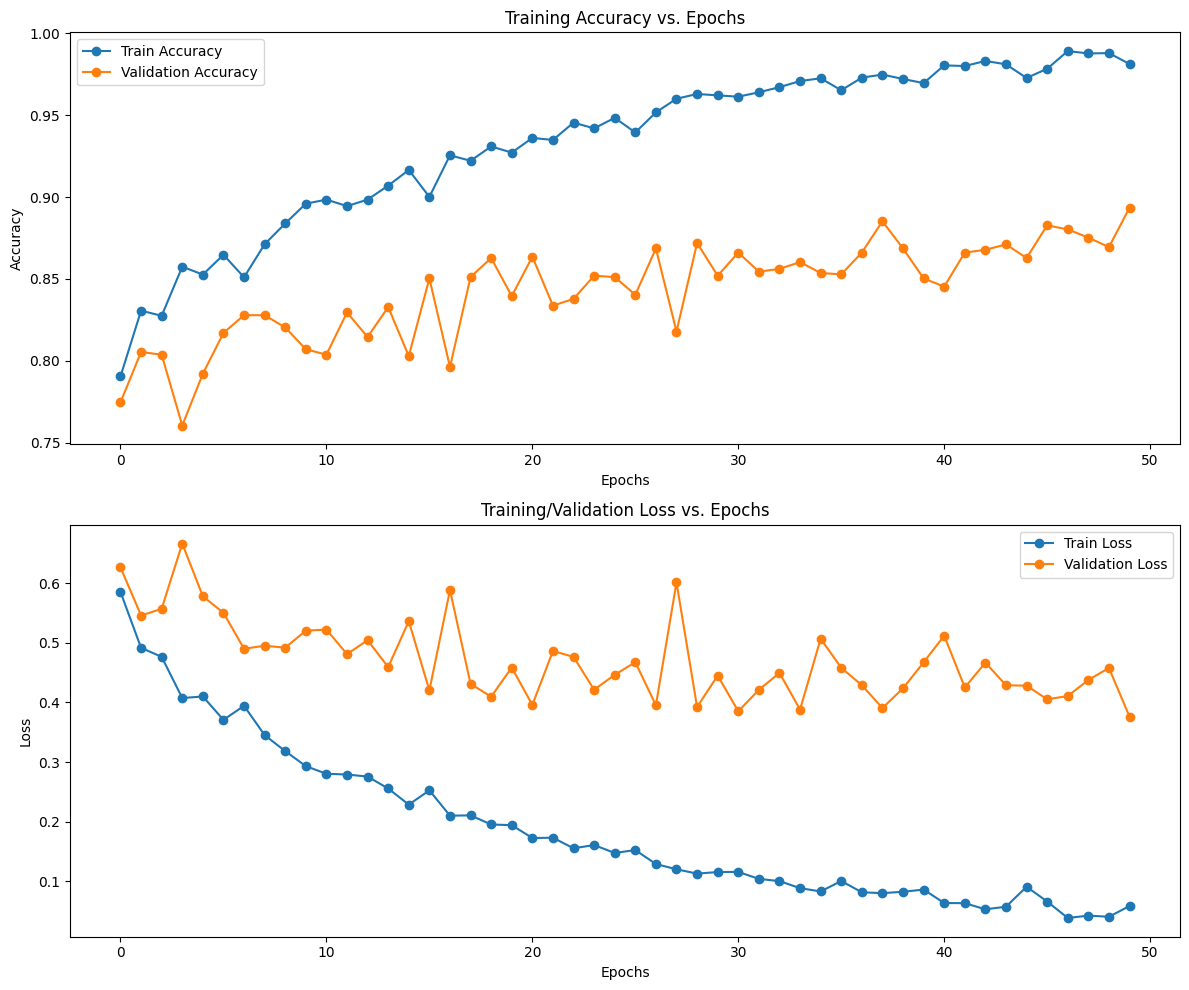

In [20]:
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred1 = model_vgg16.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 5s 118ms/step
predict time: 4.944 s


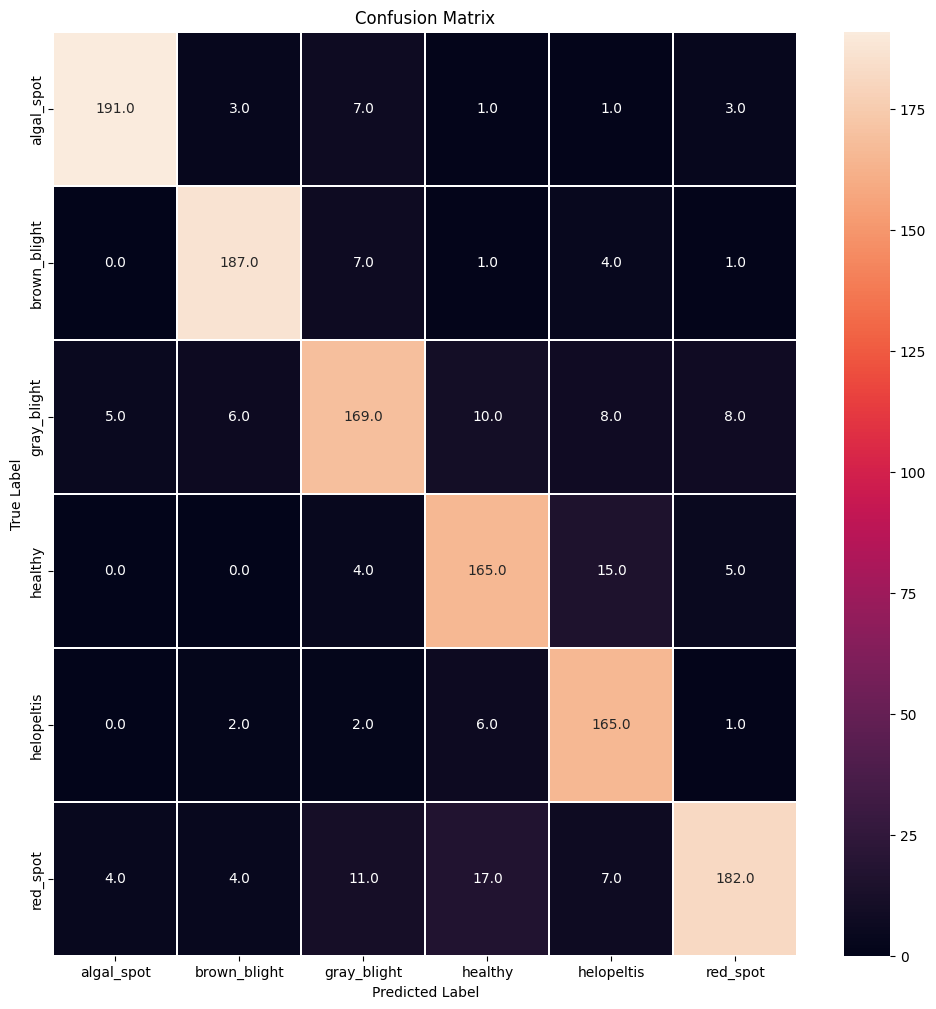

In [22]:
y_pred1 = np.argmax(Y_pred1, axis=1)
confusion_mtx = confusion_matrix(y_pred1, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report1 = classification_report(test_ds.classes, y_pred1, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1


,precision,recall,f1-score,support
algal_spot,0.927184,0.955000,0.940887,200.000000
brown_blight,0.935000,0.925743,0.930348,202.000000
gray_blight,0.820388,0.845000,0.832512,200.000000
healthy,0.873016,0.825000,0.848329,200.000000
helopeltis,0.937500,0.825000,0.877660,200.000000
red_spot,0.808889,0.910000,0.856471,200.000000
accuracy,0.881032,0.881032,0.881032,0.881032
macro avg,0.883663,0.880957,0.881034,1202.000000
weighted avg,0.883748,0.881032,0.881116,1202.000000


In [24]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred1, average='weighted')

0.7899311540230436

In [25]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred1)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.857736128541146


**VGG19**

In [13]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(224,224,3),
    pooling='max')
base_model.trainable = False # Freeze the base_model
# Let's take a look at the base model architecture
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
model_vgg19 = Sequential()
model_vgg19.add(base_model)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dense(6, activation='softmax'))
model_vgg19.compile(loss='categorical_crossentropy',
                optimizer='adamax',
                metrics=['accuracy'])

In [16]:
history3 = model_vgg19.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)

Epoch 1/50


I0000 00:00:1711439043.646529     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 [==============================] - 48s 232ms/step - loss: 1.1731 - accuracy: 0.5622 - val_loss: 1.0117 - val_accuracy: 0.6190
Epoch 2/50
151/151 [==============================] - 28s 186ms/step - loss: 0.8227 - accuracy: 0.7011 - val_loss: 0.7979 - val_accuracy: 0.7280
Epoch 3/50
151/151 [==============================] - 29s 193ms/step - loss: 0.7084 - accuracy: 0.7537 - val_loss: 0.7322 - val_accuracy: 0.7255
Epoch 4/50
151/151 [==============================] - 31s 203ms/step - loss: 0.6440 - accuracy: 0.7648 - val_loss: 0.6801 - val_accuracy: 0.7671
Epoch 5/50
151/151 [==============================] - 30s 202ms/step - loss: 0.6097 - accuracy: 0.7841 - val_loss: 0.6497 - val_accuracy: 0.7629
Epoch 6/50
151/151 [==============================] - 30s 200ms/step - loss: 0.5848 - accuracy: 0.7862 - val_loss: 0.6869 - val_accuracy: 0.7571
Epoch 7/50
151/151 [==============================] - 31s 202ms/step - loss: 0.5527 - accuracy: 0.7995 - val_loss: 0.6141 - val_accuracy: 0.7

In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

from keras.models import load_model
model_vgg19.save('vgg19_model.h5') # save the entire model with trained weights
new_model = load_model('vgg19_model.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False


model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_vgg19.summary()

Number of layers in the base model:  23


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 20290118 (77.40 MB)
Trainable params: 265734 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [18]:
from time import time
t0=time()
history3 = model_vgg19.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 32s 205ms/step - loss: 0.2064 - accuracy: 0.9326 - val_loss: 0.4418 - val_accuracy: 0.8461
Epoch 2/50
151/151 [==============================] - 31s 203ms/step - loss: 0.2030 - accuracy: 0.9319 - val_loss: 0.4590 - val_accuracy: 0.8519
Epoch 3/50
151/151 [==============================] - 30s 197ms/step - loss: 0.2044 - accuracy: 0.9319 - val_loss: 0.4573 - val_accuracy: 0.8461
Epoch 4/50
151/151 [==============================] - 30s 202ms/step - loss: 0.1972 - accuracy: 0.9369 - val_loss: 0.4764 - val_accuracy: 0.8428
Epoch 5/50
151/151 [==============================] - 31s 202ms/step - loss: 0.2005 - accuracy: 0.9323 - val_loss: 0.4857 - val_accuracy: 0.8361
Epoch 6/50
151/151 [==============================] - 30s 200ms/step - loss: 0.1997 - accuracy: 0.9371 - val_loss: 0.4657 - val_accuracy: 0.8353
Epoch 7/50
151/151 [==============================] - 30s 202ms/step - loss: 0.1985 - accuracy: 0.9361 - val_loss: 0.4574 - val_ac

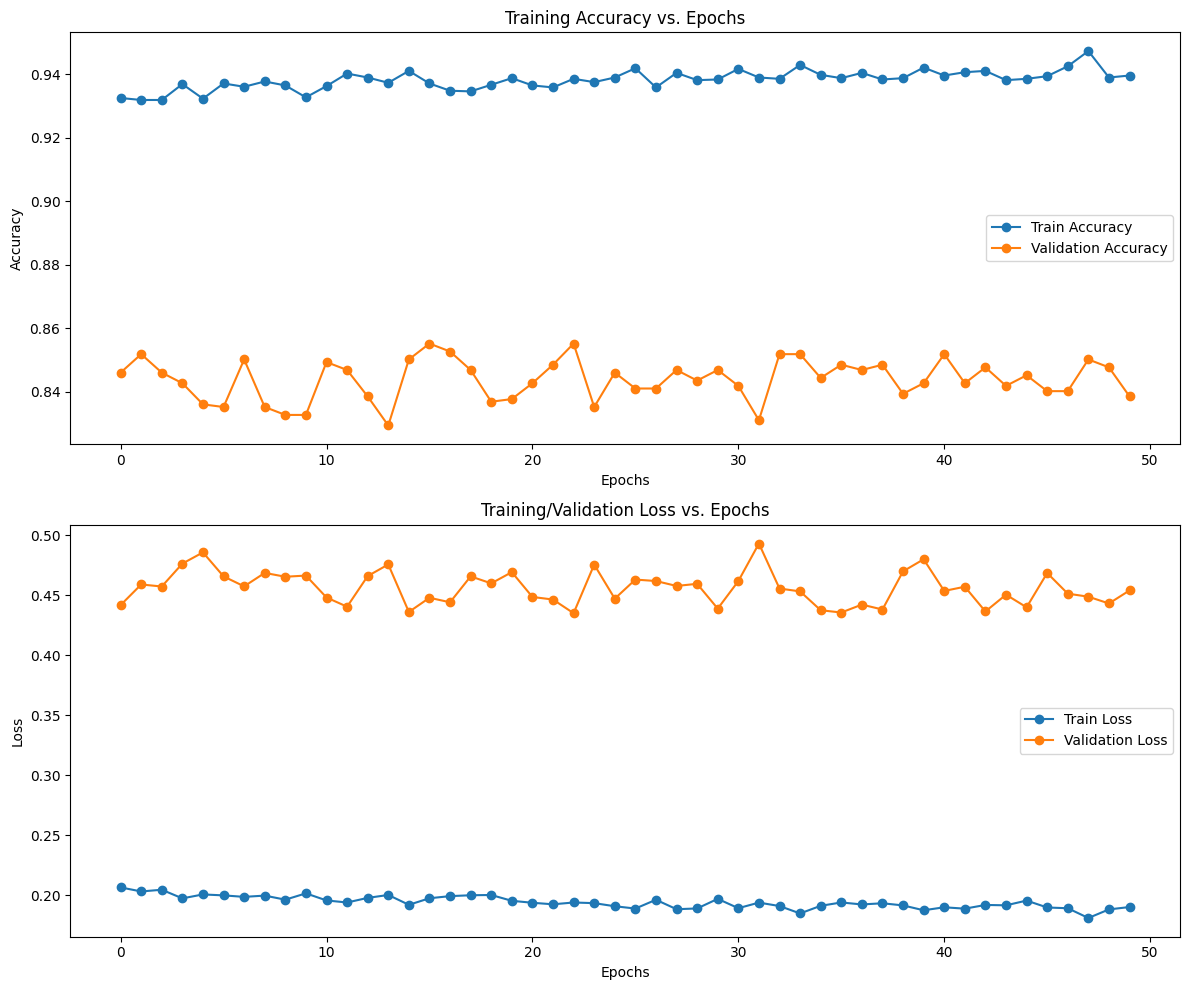

In [20]:
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred2 = model_vgg19.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 6s 147ms/step
predict time: 5.949 s


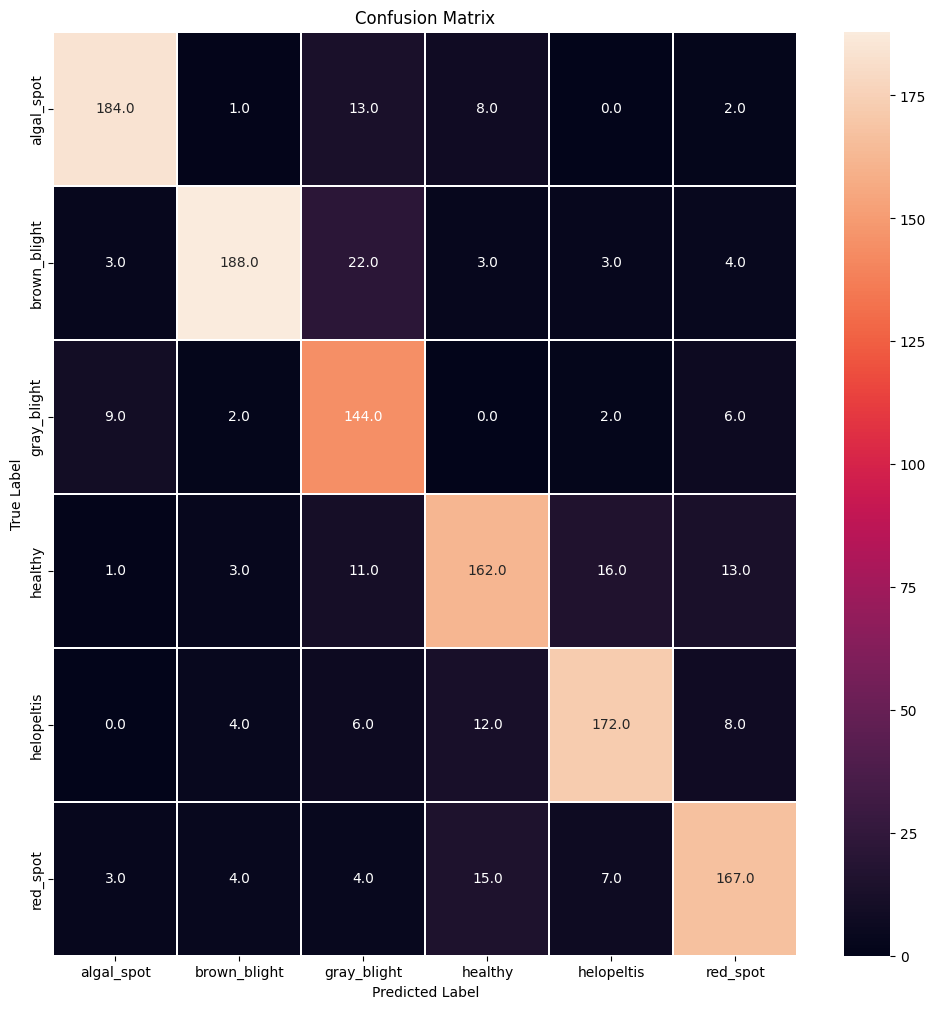

In [22]:
y_pred2 = np.argmax(Y_pred2, axis=1)
confusion_mtx = confusion_matrix(y_pred2, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report1 = classification_report(test_ds.classes, y_pred2, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.884615,0.920000,0.901961,200.00000
brown_blight,0.843049,0.930693,0.884706,202.00000
gray_blight,0.883436,0.720000,0.793388,200.00000
healthy,0.786408,0.810000,0.798030,200.00000
helopeltis,0.851485,0.860000,0.855721,200.00000
red_spot,0.835000,0.835000,0.835000,200.00000
accuracy,0.846090,0.846090,0.846090,0.84609
macro avg,0.847332,0.845949,0.844801,1202.00000
weighted avg,0.847325,0.846090,0.844867,1202.00000


In [24]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred2, average='weighted')

0.7335512417993333

In [25]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred2)

print("Matthews correlation coefficient:", mcc)


Matthews correlation coefficient: 0.8159497277667092


**ResNet50**

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50
#build the Resnet model
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False,
                      pooling='max')

resnet.trainable = False # Freeze the base_model
#show the base model summary
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_resnet = Sequential()
model_resnet.add(resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(Dense(6, activation='softmax'))
model_resnet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [19]:
from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50


I0000 00:00:1711464985.616370     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/151 [==============================] - 31s 152ms/step - loss: 2.0989 - accuracy: 0.2925 - val_loss: 1.5695 - val_accuracy: 0.3636
Epoch 2/50
151/151 [==============================] - 19s 127ms/step - loss: 1.6253 - accuracy: 0.3497 - val_loss: 1.6617 - val_accuracy: 0.2987
Epoch 3/50
151/151 [==============================] - 19s 129ms/step - loss: 1.5013 - accuracy: 0.4007 - val_loss: 1.5984 - val_accuracy: 0.3369
Epoch 4/50
151/151 [==============================] - 20s 130ms/step - loss: 1.4272 - accuracy: 0.4307 - val_loss: 1.6232 - val_accuracy: 0.3544
Epoch 5/50
151/151 [==============================] - 20s 129ms/step - loss: 1.4325 - accuracy: 0.4207 - val_loss: 1.4136 - val_accuracy: 0.4376
Epoch 6/50
151/151 [==============================] - 19s 128ms/step - loss: 1.3820 - accuracy: 0.4575 - val_loss: 1.4627 - val_accuracy: 0.4035
Epoch 7/50
151/151 [==============================] - 19s 128ms/step - loss: 1.4010 - accuracy: 0.4373 - val_loss: 1.5174 - val_accuracy: 0.3

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet.layers))

from keras.models import load_model
model_resnet.save('my_model5.h5') # save the entire model with trained weights
new_model = load_model('my_model5.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Number of layers in the base model:  176


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 24639878 (93.99 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [21]:
from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 24s 134ms/step - loss: 0.9825 - accuracy: 0.6245 - val_loss: 1.1358 - val_accuracy: 0.5449
Epoch 2/50
151/151 [==============================] - 20s 129ms/step - loss: 0.9639 - accuracy: 0.6341 - val_loss: 1.1475 - val_accuracy: 0.5424
Epoch 3/50
151/151 [==============================] - 20s 129ms/step - loss: 0.9662 - accuracy: 0.6380 - val_loss: 1.1326 - val_accuracy: 0.5507
Epoch 4/50
151/151 [==============================] - 19s 128ms/step - loss: 0.9667 - accuracy: 0.6353 - val_loss: 1.1270 - val_accuracy: 0.5632
Epoch 5/50
151/151 [==============================] - 19s 127ms/step - loss: 0.9692 - accuracy: 0.6338 - val_loss: 1.1337 - val_accuracy: 0.5557
Epoch 6/50
151/151 [==============================] - 19s 128ms/step - loss: 0.9693 - accuracy: 0.6341 - val_loss: 1.1415 - val_accuracy: 0.5566
Epoch 7/50
151/151 [==============================] - 19s 128ms/step - loss: 0.9640 - accuracy: 0.6401 - val_loss: 1.1446 - val_ac

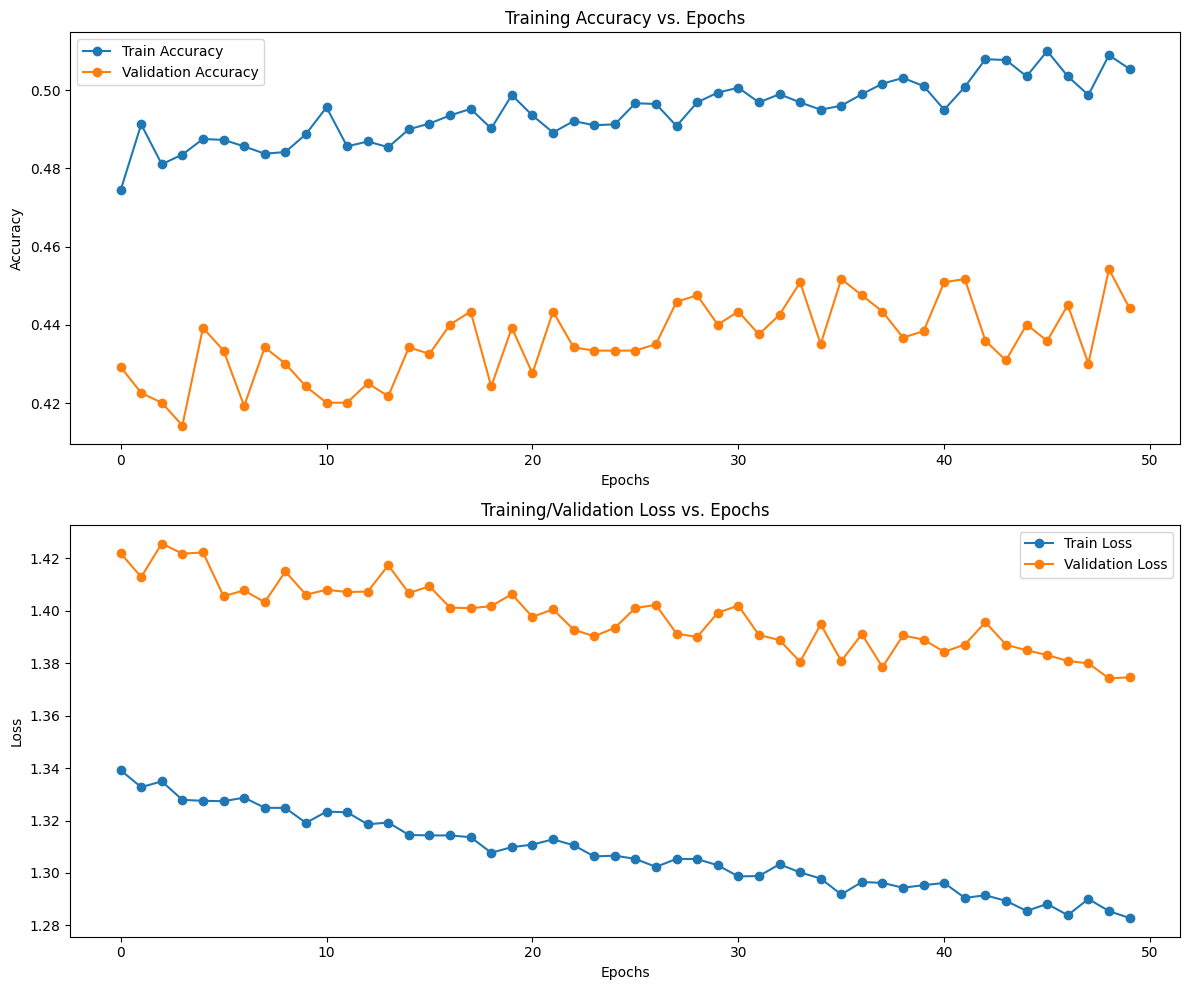

In [48]:
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred5 = model_resnet.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 5s 97ms/step
predict time: 4.689 s


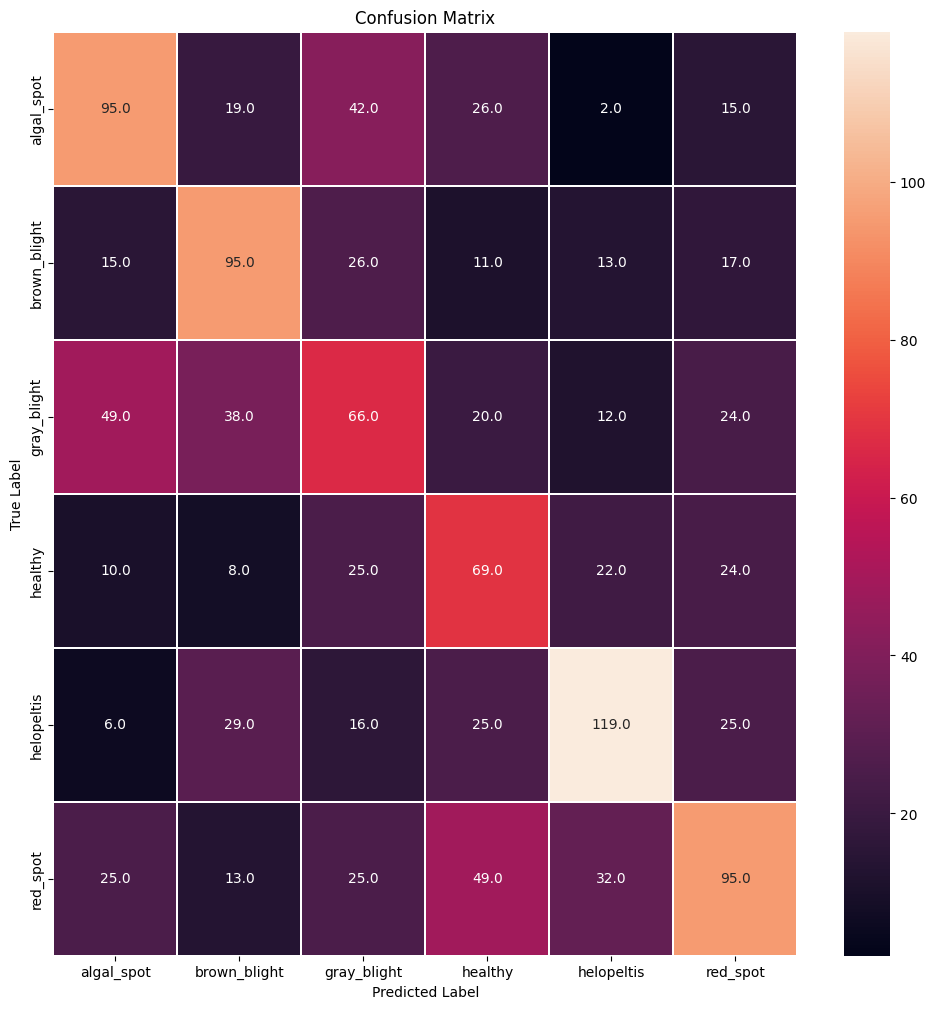

In [50]:
y_pred5 = np.argmax(Y_pred5, axis=1)
confusion_mtx = confusion_matrix(y_pred5, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [51]:
report1 = classification_report(test_ds.classes, y_pred5, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.477387,0.475000,0.476190,200.000000
brown_blight,0.536723,0.470297,0.501319,202.000000
gray_blight,0.315789,0.330000,0.322738,200.000000
healthy,0.436709,0.345000,0.385475,200.000000
helopeltis,0.540909,0.595000,0.566667,200.000000
red_spot,0.397490,0.475000,0.432802,200.000000
accuracy,0.448419,0.448419,0.448419,0.448419
macro avg,0.450835,0.448383,0.447532,1202.000000
weighted avg,0.450977,0.448419,0.447621,1202.000000


In [52]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred5, average='weighted')

0.29168683709075455

In [53]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred5)

print("Matthews correlation coefficient:", mcc)


Matthews correlation coefficient: 0.3387471764569896


**ResNet101V2**

In [54]:
from keras.applications import ResNet101V2
#build the Resnet model
resnet = ResNet101V2(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False,
                      pooling='max')

resnet.trainable = False # Freeze the base_model
#show the base model summary
resnet.summary()

171317808/171317808 [==============================] - 2s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                     

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_resnet = Sequential()
model_resnet.add(resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(Dense(6, activation='softmax'))
model_resnet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [56]:
from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds, steps_per_epoch=13)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
13/13 [==============================] - 18s 834ms/step - loss: 15.1580 - accuracy: 0.3462 - val_loss: 4.0267 - val_accuracy: 0.5549
Epoch 2/50
13/13 [==============================] - 7s 589ms/step - loss: 2.8504 - accuracy: 0.6202 - val_loss: 1.4390 - val_accuracy: 0.7280
Epoch 3/50
13/13 [==============================] - 7s 592ms/step - loss: 1.4448 - accuracy: 0.7115 - val_loss: 1.5077 - val_accuracy: 0.7030
Epoch 4/50
13/13 [==============================] - 8s 658ms/step - loss: 1.2866 - accuracy: 0.7036 - val_loss: 1.0076 - val_accuracy: 0.7729
Epoch 5/50
13/13 [==============================] - 7s 593ms/step - loss: 0.8264 - accuracy: 0.7788 - val_loss: 1.3788 - val_accuracy: 0.7038
Epoch 6/50
13/13 [==============================] - 7s 595ms/step - loss: 0.8869 - accuracy: 0.7764 - val_loss: 0.6273 - val_accuracy: 0.8186
Epoch 7/50
13/13 [==============================] - 7s 598ms/step - loss: 0.5158 - accuracy: 0.8317 - val_loss: 0.7458 - val_accuracy: 0.7962
Epoc

In [57]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet.layers))

from keras.models import load_model
model_resnet.save('my_model6.h5') # save the entire model with trained weights
new_model = load_model('my_model6.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Number of layers in the base model:  378


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dense_11 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 43678726 (166.62 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________


In [58]:
from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 37s 204ms/step - loss: 0.1107 - accuracy: 0.9627 - val_loss: 0.2647 - val_accuracy: 0.9176
Epoch 2/50
151/151 [==============================] - 29s 192ms/step - loss: 0.0881 - accuracy: 0.9706 - val_loss: 0.2619 - val_accuracy: 0.9118
Epoch 3/50
151/151 [==============================] - 28s 188ms/step - loss: 0.0810 - accuracy: 0.9731 - val_loss: 0.2634 - val_accuracy: 0.9135
Epoch 4/50
151/151 [==============================] - 29s 189ms/step - loss: 0.0718 - accuracy: 0.9779 - val_loss: 0.2409 - val_accuracy: 0.9193
Epoch 5/50
151/151 [==============================] - 29s 190ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.2378 - val_accuracy: 0.9193
Epoch 6/50
151/151 [==============================] - 29s 190ms/step - loss: 0.0691 - accuracy: 0.9811 - val_loss: 0.2362 - val_accuracy: 0.9210
Epoch 7/50
151/151 [==============================] - 29s 189ms/step - loss: 0.0632 - accuracy: 0.9813 - val_loss: 0.2472 - val_ac

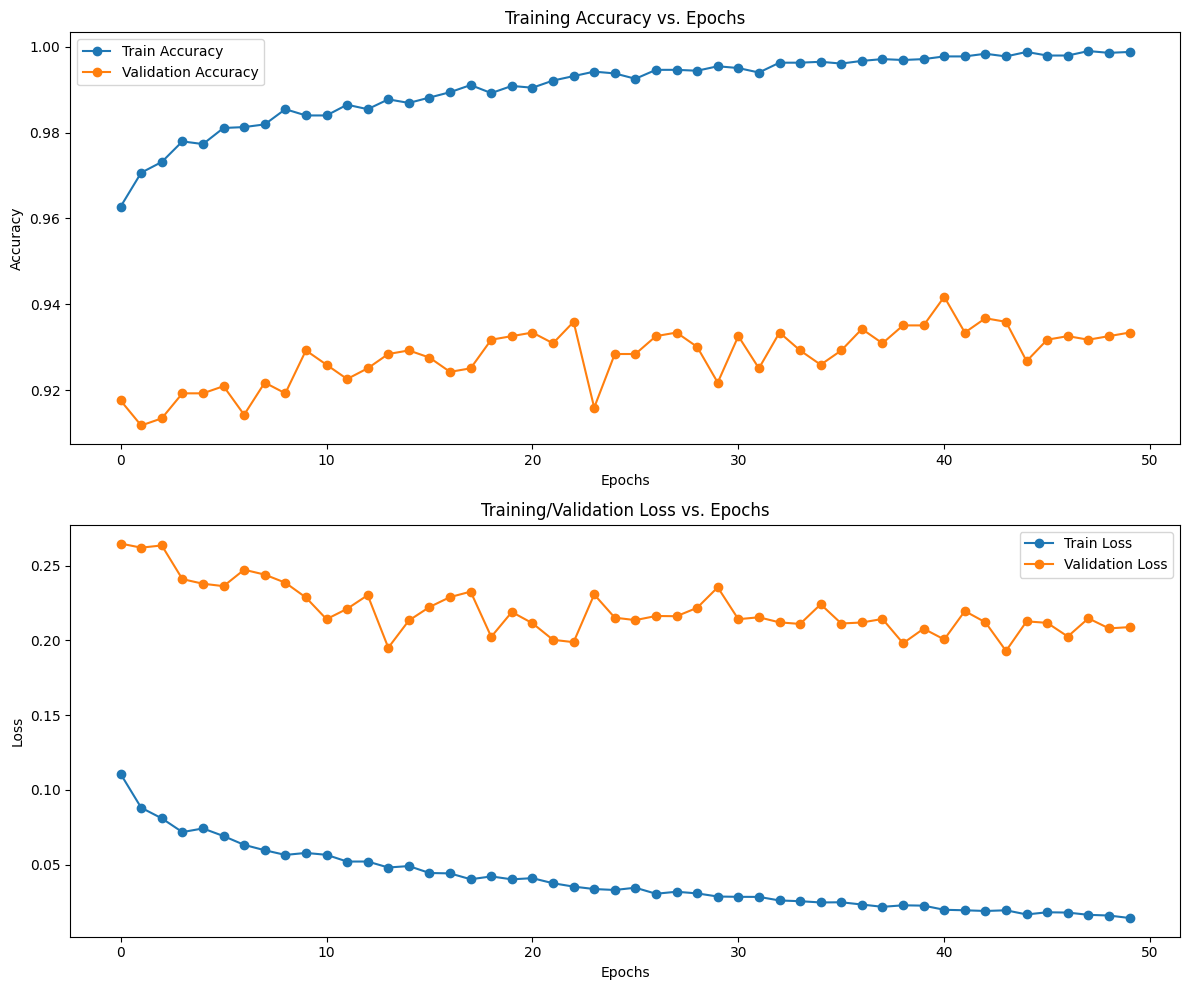

In [59]:
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred6 = model_resnet.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 7s 147ms/step
predict time: 7.264 s


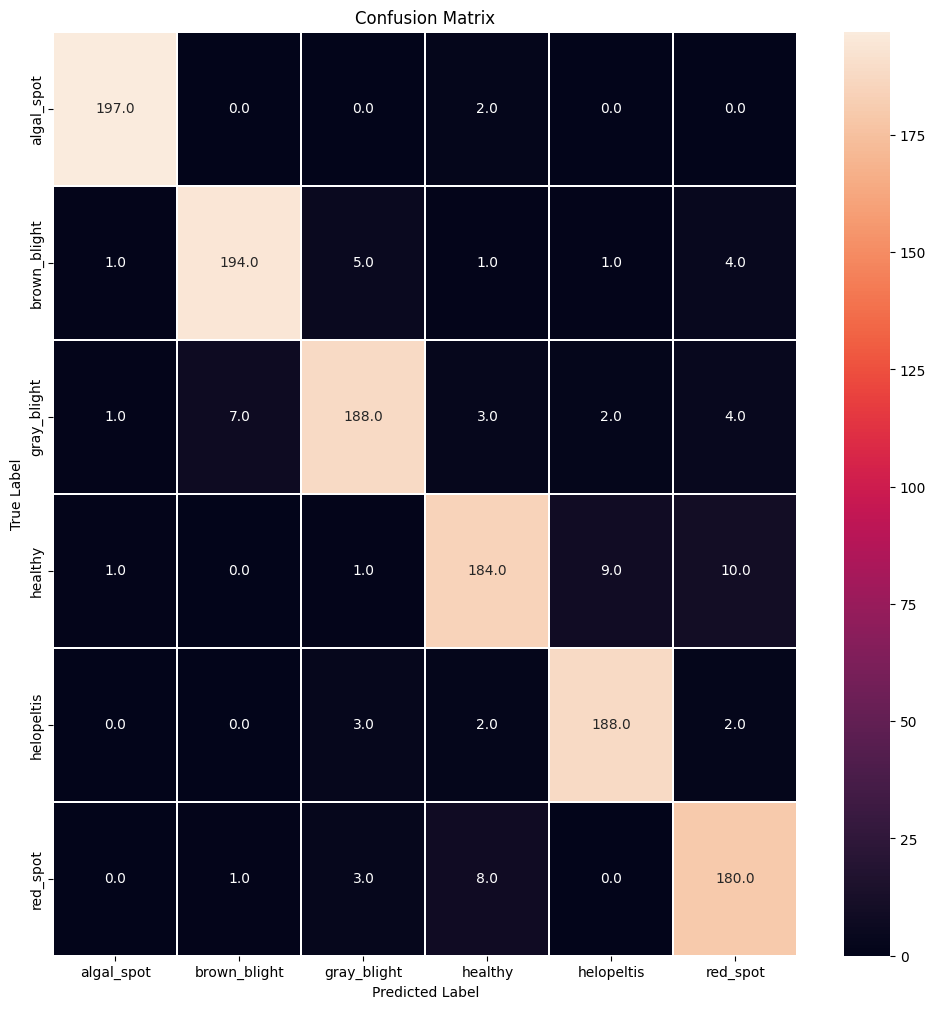

In [61]:
y_pred6 = np.argmax(Y_pred6, axis=1)
confusion_mtx = confusion_matrix(y_pred6, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [62]:
report1 = classification_report(test_ds.classes, y_pred6, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.989950,0.985000,0.987469,200.000000
brown_blight,0.941748,0.960396,0.950980,202.000000
gray_blight,0.917073,0.940000,0.928395,200.000000
healthy,0.897561,0.920000,0.908642,200.000000
helopeltis,0.964103,0.940000,0.951899,200.000000
red_spot,0.937500,0.900000,0.918367,200.000000
accuracy,0.940932,0.940932,0.940932,0.940932
macro avg,0.941322,0.940899,0.940959,1202.000000
weighted avg,0.941323,0.940932,0.940975,1202.000000


In [63]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred6, average='weighted')

0.8896943091635636

In [64]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred6)

print("Matthews correlation coefficient:", mcc)


Matthews correlation coefficient: 0.9291776678850041


**ResNet152V2**

In [65]:
from keras.applications import ResNet152V2
#build the Resnet model
resnet = ResNet152V2(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False,
                      pooling='max')

resnet.trainable = False # Freeze the base_model
#show the base model summary
resnet.summary()

234545216/234545216 [==============================] - 2s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                     

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_resnet = Sequential()
model_resnet.add(resnet)
model_resnet.add(Flatten())
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(Dense(6, activation='softmax'))
model_resnet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


In [67]:

from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds, steps_per_epoch=13)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds




Epoch 1/50
13/13 [==============================] - 23s 1s/step - loss: 19.5627 - accuracy: 0.2909 - val_loss: 7.6475 - val_accuracy: 0.4035
Epoch 2/50
13/13 [==============================] - 10s 846ms/step - loss: 4.5707 - accuracy: 0.5529 - val_loss: 2.5833 - val_accuracy: 0.6223
Epoch 3/50
13/13 [==============================] - 10s 851ms/step - loss: 2.1692 - accuracy: 0.6707 - val_loss: 1.7909 - val_accuracy: 0.6672
Epoch 4/50
13/13 [==============================] - 11s 855ms/step - loss: 1.4354 - accuracy: 0.7163 - val_loss: 1.2796 - val_accuracy: 0.7221
Epoch 5/50
13/13 [==============================] - 11s 860ms/step - loss: 0.9950 - accuracy: 0.7812 - val_loss: 0.9188 - val_accuracy: 0.7546
Epoch 6/50
13/13 [==============================] - 11s 860ms/step - loss: 0.7793 - accuracy: 0.7837 - val_loss: 0.9225 - val_accuracy: 0.7471
Epoch 7/50
13/13 [==============================] - 11s 859ms/step - loss: 0.7070 - accuracy: 0.8125 - val_loss: 0.6875 - val_accuracy: 0.7879
E

In [68]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet.layers))

from keras.models import load_model
model_resnet.save('my_model8.h5') # save the entire model with trained weights
new_model = load_model('my_model8.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 18

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()


Number of layers in the base model:  565


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 59383814 (226.53 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


In [69]:

from time import time
t0=time()
history5 = model_resnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds



Epoch 1/50
151/151 [==============================] - 52s 282ms/step - loss: 0.1082 - accuracy: 0.9619 - val_loss: 0.2927 - val_accuracy: 0.8977
Epoch 2/50
151/151 [==============================] - 41s 269ms/step - loss: 0.0860 - accuracy: 0.9713 - val_loss: 0.2444 - val_accuracy: 0.9068
Epoch 3/50
151/151 [==============================] - 41s 270ms/step - loss: 0.0847 - accuracy: 0.9734 - val_loss: 0.2425 - val_accuracy: 0.9118
Epoch 4/50
151/151 [==============================] - 41s 272ms/step - loss: 0.0766 - accuracy: 0.9756 - val_loss: 0.2405 - val_accuracy: 0.9168
Epoch 5/50
151/151 [==============================] - 41s 274ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.2461 - val_accuracy: 0.9085
Epoch 6/50
151/151 [==============================] - 42s 275ms/step - loss: 0.0739 - accuracy: 0.9748 - val_loss: 0.2455 - val_accuracy: 0.9093
Epoch 7/50
151/151 [==============================] - 42s 275ms/step - loss: 0.0723 - accuracy: 0.9773 - val_loss: 0.2447 - val_ac

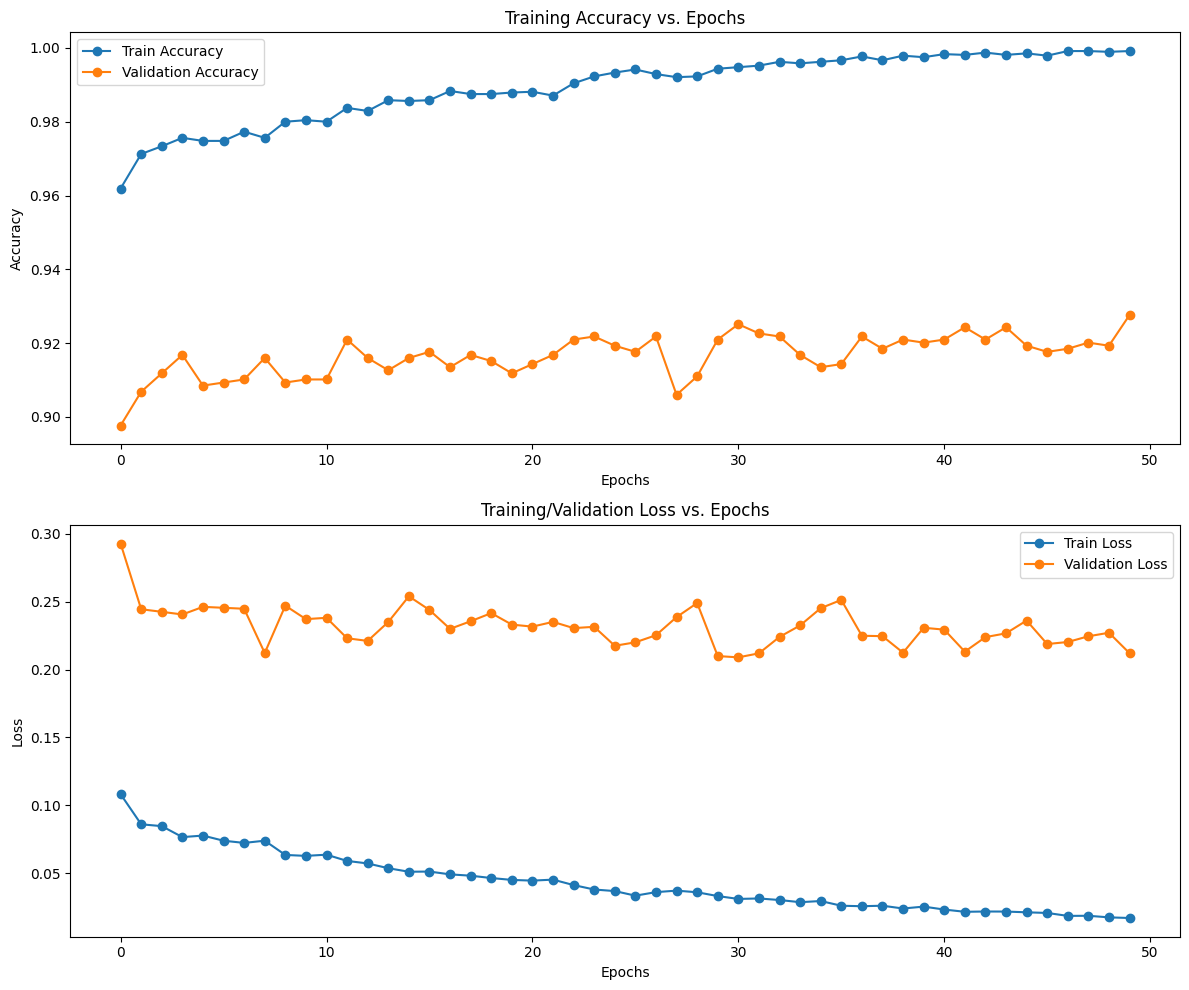

In [70]:

train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


In [71]:

from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred8 = model_resnet.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")


38/38 [==============================] - 10s 205ms/step
predict time: 10.276 s


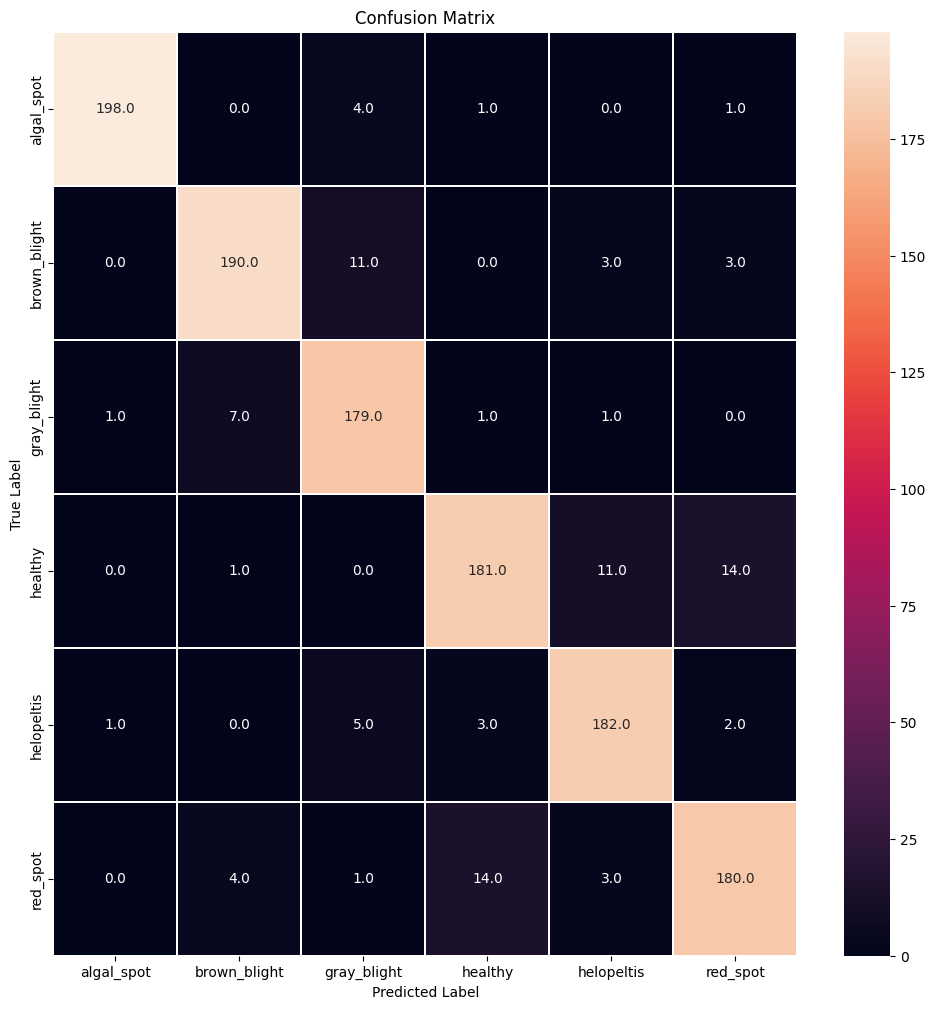

In [72]:

y_pred8 = np.argmax(Y_pred8, axis=1)
confusion_mtx = confusion_matrix(y_pred8, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()


In [73]:
report1 = classification_report(test_ds.classes, y_pred8, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1



,precision,recall,f1-score,support
algal_spot,0.970588,0.990000,0.980198,200.000000
brown_blight,0.917874,0.940594,0.929095,202.000000
gray_blight,0.947090,0.895000,0.920308,200.000000
healthy,0.874396,0.905000,0.889435,200.000000
helopeltis,0.943005,0.910000,0.926209,200.000000
red_spot,0.891089,0.900000,0.895522,200.000000
accuracy,0.923461,0.923461,0.923461,0.923461
macro avg,0.924007,0.923432,0.923461,1202.000000
weighted avg,0.923997,0.923461,0.923471,1202.000000


In [74]:


from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred8, average='weighted')


0.8592440460825927

In [75]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred8)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.9082516439699476


**MobileNet**

In [76]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = tf.keras.applications.mobilenet.MobileNet(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(224,224,3),
    pooling='max')
base_model.trainable = False # Freeze the base_model
# Let's take a look at the base model architecture
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_mobilenet = Sequential()
model_mobilenet.add(base_model)
model_mobilenet.add(Flatten())
model_mobilenet.add(Dense(512, activation='relu'))
model_mobilenet.add(Dense(6, activation='softmax'))
model_mobilenet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [78]:
from time import time
t0=time()
history5 = model_mobilenet.fit(train_ds, epochs = 50, validation_data = test_ds, steps_per_epoch=13)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
13/13 [==============================] - 7s 341ms/step - loss: 9.8956 - accuracy: 0.2603 - val_loss: 4.2707 - val_accuracy: 0.3835
Epoch 2/50
13/13 [==============================] - 3s 217ms/step - loss: 2.8269 - accuracy: 0.4712 - val_loss: 2.0943 - val_accuracy: 0.4160
Epoch 3/50
13/13 [==============================] - 3s 211ms/step - loss: 1.5803 - accuracy: 0.5601 - val_loss: 1.9097 - val_accuracy: 0.4834
Epoch 4/50
13/13 [==============================] - 3s 204ms/step - loss: 0.8323 - accuracy: 0.6971 - val_loss: 0.8051 - val_accuracy: 0.6988
Epoch 5/50
13/13 [==============================] - 3s 220ms/step - loss: 0.7033 - accuracy: 0.7524 - val_loss: 0.6509 - val_accuracy: 0.7662
Epoch 6/50
13/13 [==============================] - 3s 228ms/step - loss: 0.6263 - accuracy: 0.7861 - val_loss: 0.6910 - val_accuracy: 0.7512
Epoch 7/50
13/13 [==============================] - 3s 215ms/step - loss: 0.5919 - accuracy: 0.7909 - val_loss: 0.5937 - val_accuracy: 0.7770
Epoch 

In [79]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

from keras.models import load_model
model_mobilenet.save('my_model4.h5') # save the entire model with trained weights
new_model = load_model('my_model4.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False


model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_mobilenet.summary()

Number of layers in the base model:  87


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1024)              3228864   
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dense_15 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 3756742 (14.33 MB)
Trainable params: 527878 (2.01 MB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [80]:
from time import time
t0=time()
history5 = model_mobilenet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 12s 67ms/step - loss: 0.1248 - accuracy: 0.9577 - val_loss: 0.2781 - val_accuracy: 0.8993
Epoch 2/50
151/151 [==============================] - 10s 64ms/step - loss: 0.1125 - accuracy: 0.9625 - val_loss: 0.2727 - val_accuracy: 0.9110
Epoch 3/50
151/151 [==============================] - 10s 66ms/step - loss: 0.1119 - accuracy: 0.9619 - val_loss: 0.2859 - val_accuracy: 0.9052
Epoch 4/50
151/151 [==============================] - 10s 66ms/step - loss: 0.1068 - accuracy: 0.9652 - val_loss: 0.2775 - val_accuracy: 0.9085
Epoch 5/50
151/151 [==============================] - 11s 71ms/step - loss: 0.1023 - accuracy: 0.9677 - val_loss: 0.2740 - val_accuracy: 0.9043
Epoch 6/50
151/151 [==============================] - 11s 71ms/step - loss: 0.1053 - accuracy: 0.9646 - val_loss: 0.2809 - val_accuracy: 0.9002
Epoch 7/50
151/151 [==============================] - 10s 66ms/step - loss: 0.1022 - accuracy: 0.9663 - val_loss: 0.2639 - val_accuracy:

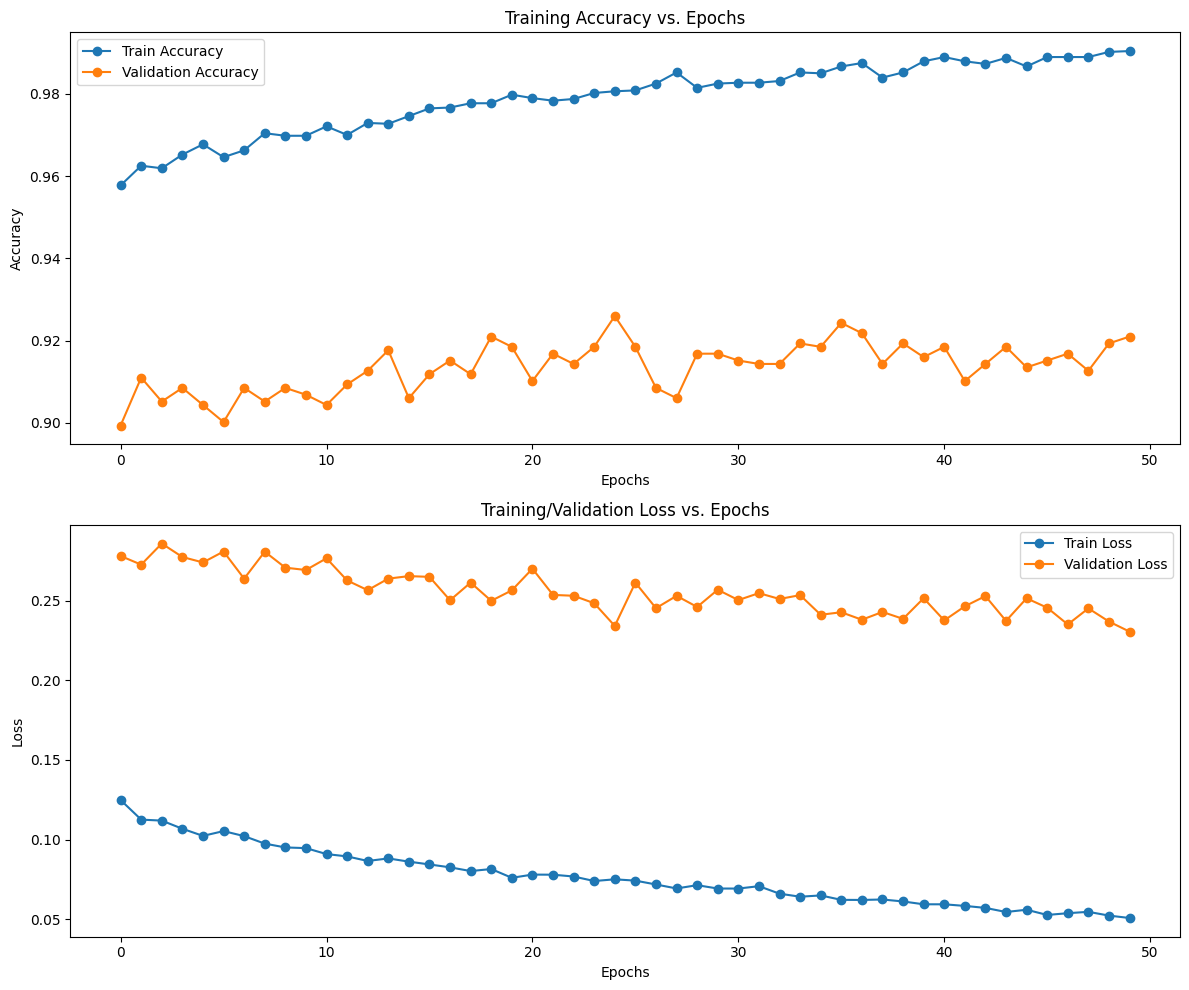

In [81]:
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred4 = model_mobilenet.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 3s 55ms/step
predict time: 2.674 s


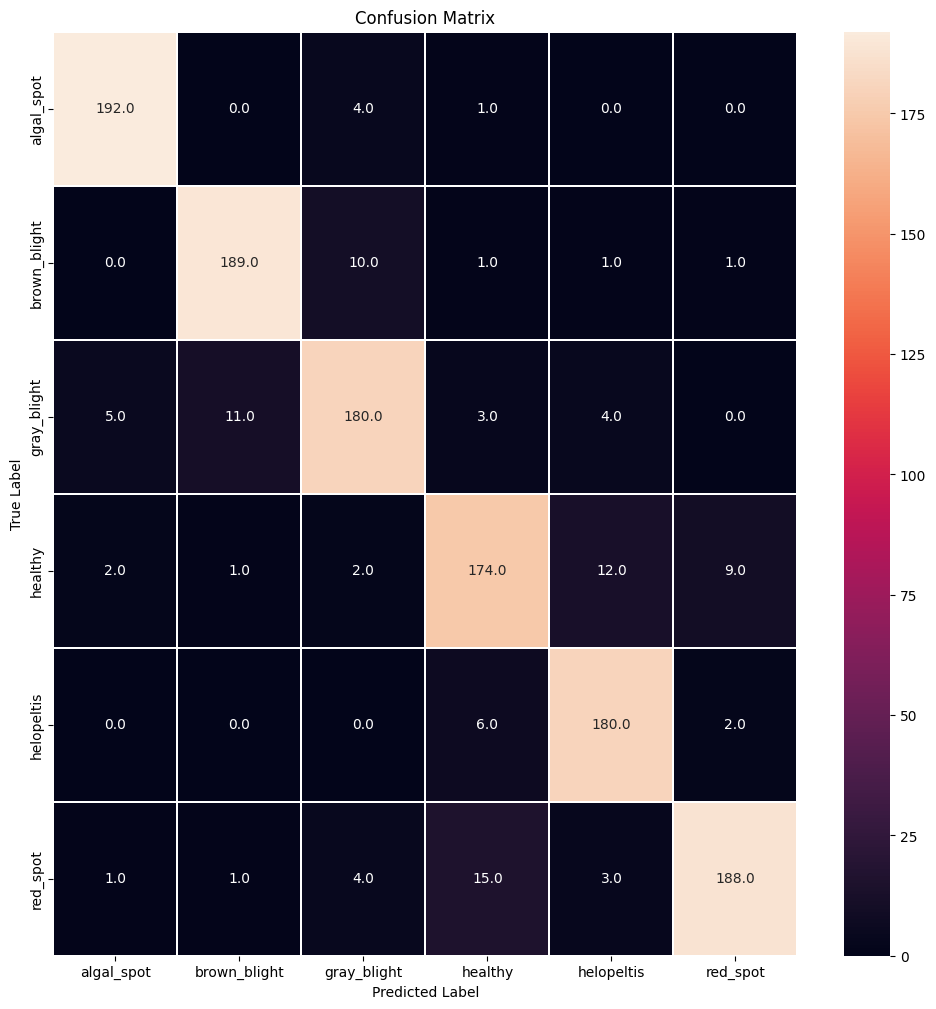

In [83]:
y_pred4 = np.argmax(Y_pred4, axis=1)
confusion_mtx = confusion_matrix(y_pred4, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [84]:
report1 = classification_report(test_ds.classes, y_pred4, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.974619,0.960000,0.967254,200.000000
brown_blight,0.935644,0.935644,0.935644,202.000000
gray_blight,0.886700,0.900000,0.893300,200.000000
healthy,0.870000,0.870000,0.870000,200.000000
helopeltis,0.957447,0.900000,0.927835,200.000000
red_spot,0.886792,0.940000,0.912621,200.000000
accuracy,0.917637,0.917637,0.917637,0.917637
macro avg,0.918534,0.917607,0.917776,1202.000000
weighted avg,0.918562,0.917637,0.917806,1202.000000


In [85]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred4, average='weighted')

0.8496177292774415

In [86]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred4)

print("Matthews correlation coefficient:", mcc)

Matthews correlation coefficient: 0.9012789904055566


**MobileNetV2**

In [22]:
from keras.applications import  MobileNetV2
#build the Resnet model
base_model = MobileNetV2(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False,
                      pooling='max')

base_model.trainable = False # Freeze the base_model
#show the base model summary
base_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_mobilenetv2 = Sequential()
model_mobilenetv2.add(base_model)
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation='relu'))
model_mobilenetv2.add(Dense(6, activation='sigmoid'))
model_mobilenetv2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [24]:
from time import time
t0=time()
history5 = model_mobilenetv2.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 18s 90ms/step - loss: 1.6710 - accuracy: 0.6975 - val_loss: 0.6295 - val_accuracy: 0.7995
Epoch 2/50
151/151 [==============================] - 11s 71ms/step - loss: 0.4304 - accuracy: 0.8501 - val_loss: 0.5720 - val_accuracy: 0.7970
Epoch 3/50
151/151 [==============================] - 10s 69ms/step - loss: 0.3578 - accuracy: 0.8684 - val_loss: 0.3669 - val_accuracy: 0.8727
Epoch 4/50
151/151 [==============================] - 10s 67ms/step - loss: 0.2522 - accuracy: 0.9090 - val_loss: 0.2690 - val_accuracy: 0.9018
Epoch 5/50
151/151 [==============================] - 11s 69ms/step - loss: 0.2065 - accuracy: 0.9292 - val_loss: 0.3259 - val_accuracy: 0.8902
Epoch 6/50
151/151 [==============================] - 10s 67ms/step - loss: 0.1873 - accuracy: 0.9332 - val_loss: 0.2567 - val_accuracy: 0.9052
Epoch 7/50
151/151 [==============================] - 10s 68ms/step - loss: 0.1853 - accuracy: 0.9351 - val_loss: 0.3210 - val_accuracy:

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

from keras.models import load_model
model_mobilenetv2.save('my_model7.h5') # save the entire model with trained weights
new_model = load_model('my_model7.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 64

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_mobilenetv2.summary()

Number of layers in the base model:  155
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 2916934 (11.13 MB)
Trainable params: 658950 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [28]:
from time import time
t0=time()
history5 = model_mobilenetv2.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 14s 76ms/step - loss: 3.4198e-04 - accuracy: 1.0000 - val_loss: 0.2155 - val_accuracy: 0.9501
Epoch 2/50
151/151 [==============================] - 10s 67ms/step - loss: 2.9603e-04 - accuracy: 1.0000 - val_loss: 0.2208 - val_accuracy: 0.9409
Epoch 3/50
151/151 [==============================] - 10s 68ms/step - loss: 2.9969e-04 - accuracy: 1.0000 - val_loss: 0.2377 - val_accuracy: 0.9476
Epoch 4/50
151/151 [==============================] - 10s 69ms/step - loss: 3.3579e-04 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 0.9459
Epoch 5/50
151/151 [==============================] - 10s 66ms/step - loss: 3.1605e-04 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 0.9517
Epoch 6/50
151/151 [==============================] - 11s 71ms/step - loss: 3.0765e-04 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9376
Epoch 7/50
151/151 [==============================] - 10s 66ms/step - loss: 2.8123e-04 - accuracy: 1.0000 - val_

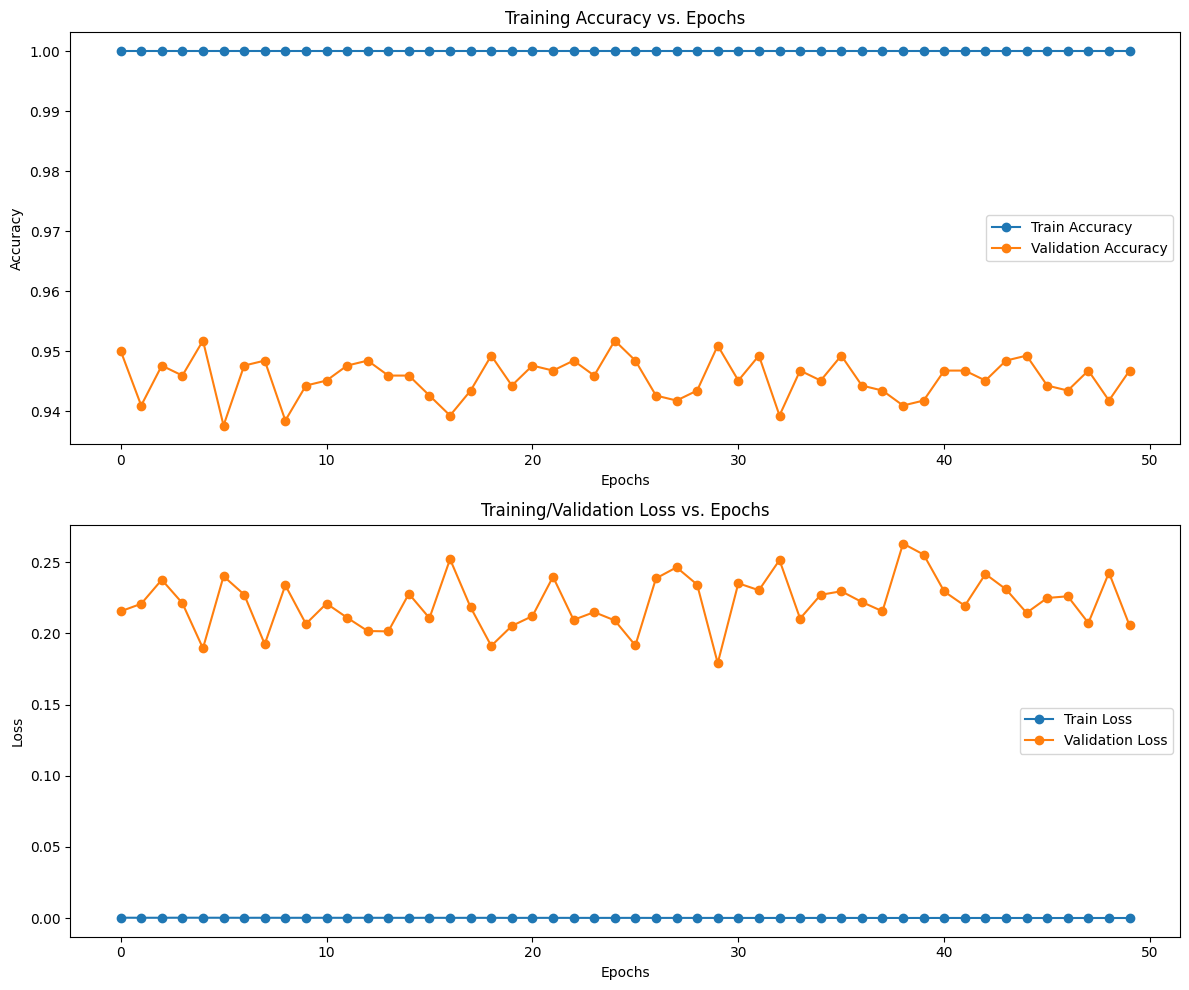

In [29]:
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred7 = model_mobilenetv2.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 3s 49ms/step
predict time: 3.009 s


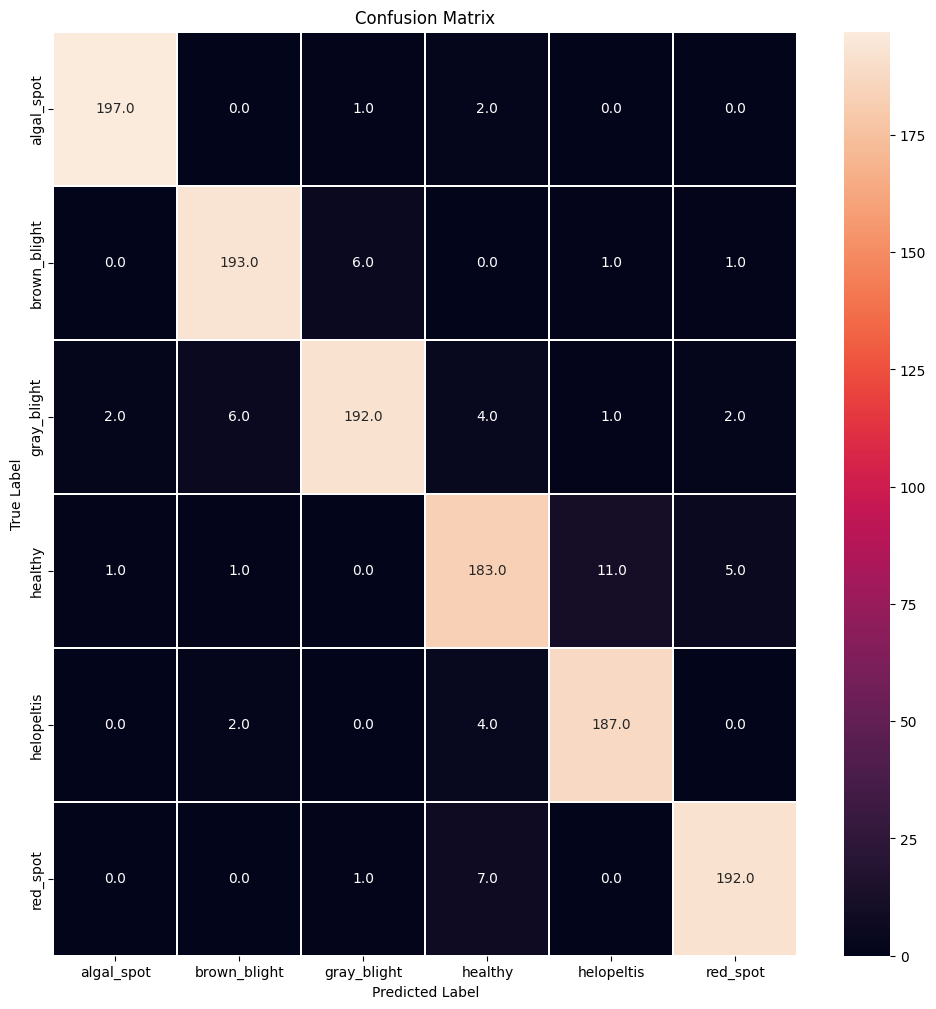

In [31]:
y_pred7 = np.argmax(Y_pred7, axis=1)
confusion_mtx = confusion_matrix(y_pred7, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [32]:
report1 = classification_report(test_ds.classes, y_pred7, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.985000,0.985000,0.985000,200.000000
brown_blight,0.960199,0.955446,0.957816,202.000000
gray_blight,0.927536,0.960000,0.943489,200.000000
healthy,0.910448,0.915000,0.912718,200.000000
helopeltis,0.968912,0.935000,0.951654,200.000000
red_spot,0.960000,0.960000,0.960000,200.000000
accuracy,0.951747,0.951747,0.951747,0.951747
macro avg,0.952016,0.951741,0.951780,1202.000000
weighted avg,0.952029,0.951747,0.951790,1202.000000


In [33]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred7, average='weighted')

0.9088183286952299

In [34]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred7)

print("Matthews correlation coefficient:", mcc)


Matthews correlation coefficient: 0.9421355676152215


**Xception**

In [100]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
base_model = tf.keras.applications.xception.Xception(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    include_top=False,  # Do not include the ImageNet classifier at the top.
    input_shape=(224,224,3),
    pooling='max')
base_model.trainable = False # Freeze the base_model
# Let's take a look at the base model architecture
base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_8[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(Flatten())
model_xception.add(Dense(512, activation='relu'))
model_xception.add(Dense(6, activation='softmax'))
model_xception.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_xception.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dense_21 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 21913646 (83.59 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [102]:
from time import time
t0=time()
history4 = model_xception.fit(train_ds, epochs = 50, validation_data = test_ds, steps_per_epoch=10)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
10/10 [==============================] - 15s 925ms/step - loss: 3.8880 - accuracy: 0.2656 - val_loss: 1.6160 - val_accuracy: 0.4800
Epoch 2/50
10/10 [==============================] - 6s 636ms/step - loss: 1.4875 - accuracy: 0.5250 - val_loss: 1.2920 - val_accuracy: 0.5541
Epoch 3/50
10/10 [==============================] - 6s 639ms/step - loss: 0.9213 - accuracy: 0.6562 - val_loss: 1.1190 - val_accuracy: 0.6148
Epoch 4/50
10/10 [==============================] - 6s 641ms/step - loss: 0.8017 - accuracy: 0.6844 - val_loss: 0.8547 - val_accuracy: 0.6805
Epoch 5/50
10/10 [==============================] - 6s 637ms/step - loss: 0.9426 - accuracy: 0.6625 - val_loss: 0.7973 - val_accuracy: 0.7047
Epoch 6/50
10/10 [==============================] - 6s 645ms/step - loss: 0.7187 - accuracy: 0.7250 - val_loss: 0.7043 - val_accuracy: 0.7546
Epoch 7/50
10/10 [==============================] - 6s 646ms/step - loss: 0.5844 - accuracy: 0.8031 - val_loss: 0.7545 - val_accuracy: 0.7213
Epoch

In [103]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

from keras.models import load_model
model_xception.save('my_model3.h5') # save the entire model with trained weights
new_model = load_model('my_model3.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False


model_xception.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_xception.summary()

Number of layers in the base model:  133


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dense_21 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 21913646 (83.59 MB)
Trainable params: 1052166 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [104]:
from time import time
t0=time()
history4 = model_xception.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
151/151 [==============================] - 28s 163ms/step - loss: 0.2623 - accuracy: 0.9107 - val_loss: 0.3420 - val_accuracy: 0.8794
Epoch 2/50
151/151 [==============================] - 24s 161ms/step - loss: 0.2169 - accuracy: 0.9303 - val_loss: 0.3362 - val_accuracy: 0.8827
Epoch 3/50
151/151 [==============================] - 25s 168ms/step - loss: 0.2150 - accuracy: 0.9296 - val_loss: 0.3208 - val_accuracy: 0.8860
Epoch 4/50
151/151 [==============================] - 26s 170ms/step - loss: 0.2080 - accuracy: 0.9340 - val_loss: 0.3379 - val_accuracy: 0.8777
Epoch 5/50
151/151 [==============================] - 25s 168ms/step - loss: 0.2039 - accuracy: 0.9351 - val_loss: 0.3155 - val_accuracy: 0.8860
Epoch 6/50
151/151 [==============================] - 25s 168ms/step - loss: 0.1935 - accuracy: 0.9334 - val_loss: 0.3277 - val_accuracy: 0.8877
Epoch 7/50
151/151 [==============================] - 26s 169ms/step - loss: 0.1906 - accuracy: 0.9405 - val_loss: 0.3110 - val_ac

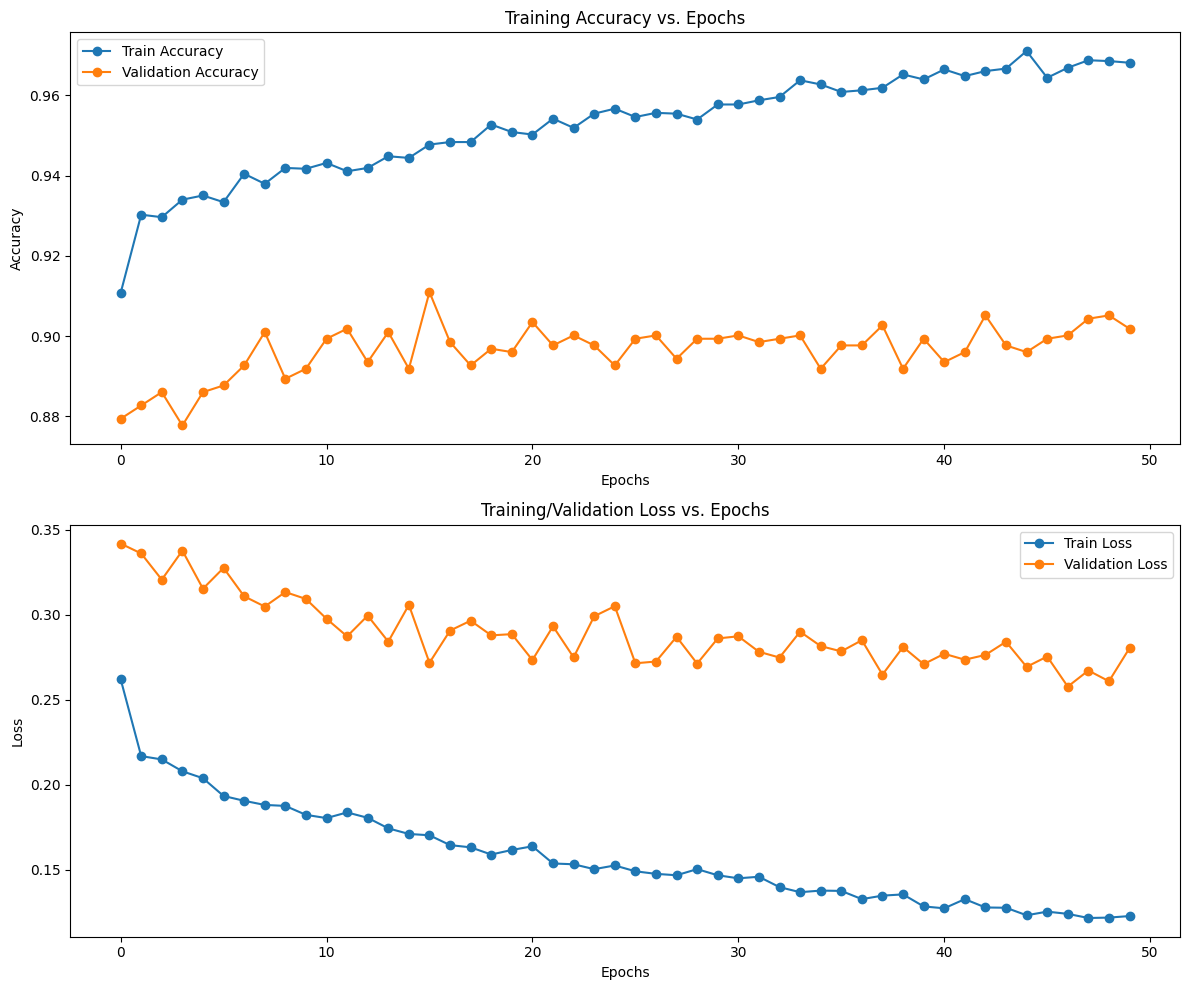

In [105]:
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']

train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred3 = model_xception.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

38/38 [==============================] - 6s 129ms/step
predict time: 5.749 s


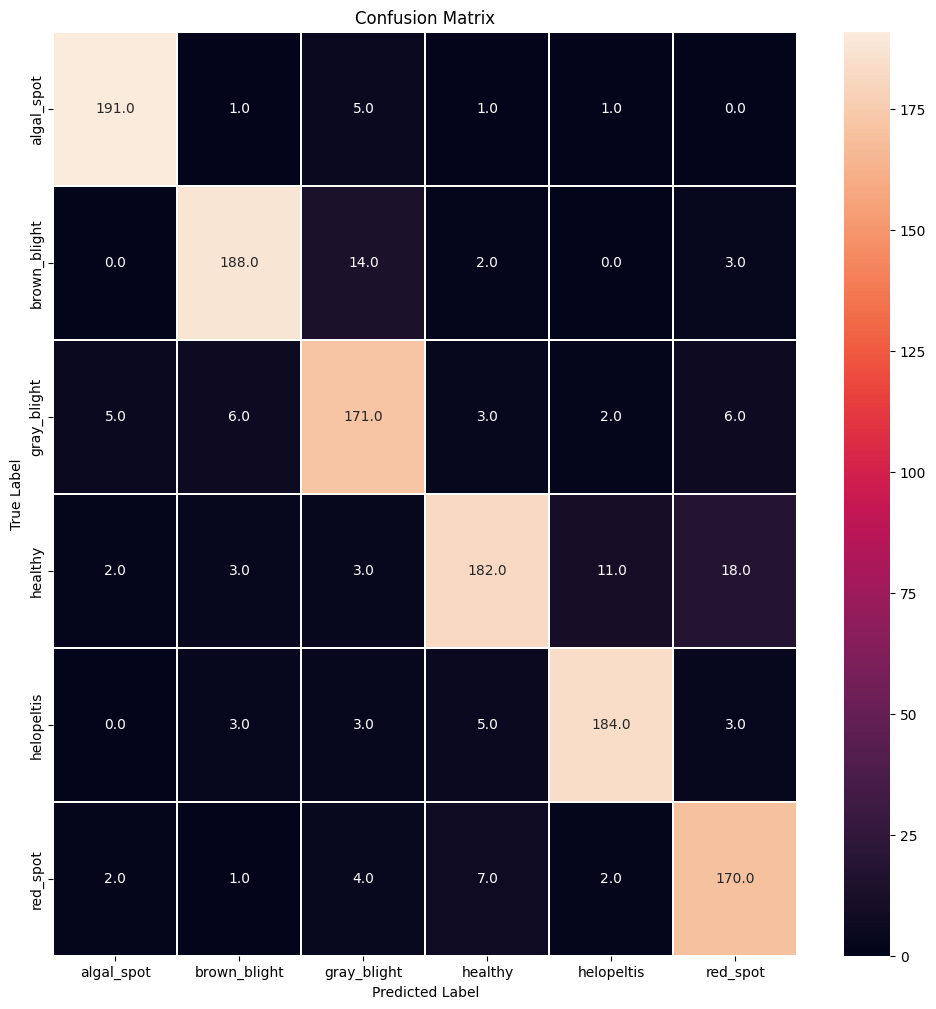

In [107]:
y_pred3 = np.argmax(Y_pred3, axis=1)
confusion_mtx = confusion_matrix(y_pred3, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()



In [108]:
report1 = classification_report(test_ds.classes, y_pred3, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
algal_spot,0.959799,0.955000,0.957393,200.000000
brown_blight,0.908213,0.930693,0.919315,202.000000
gray_blight,0.886010,0.855000,0.870229,200.000000
healthy,0.831050,0.910000,0.868735,200.000000
helopeltis,0.929293,0.920000,0.924623,200.000000
red_spot,0.913978,0.850000,0.880829,200.000000
accuracy,0.903494,0.903494,0.903494,0.903494
macro avg,0.904724,0.903449,0.903521,1202.000000
weighted avg,0.904730,0.903494,0.903547,1202.000000


In [109]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred3, average='weighted')

0.8257084246259825

In [110]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred3)

print("Matthews correlation coefficient:", mcc)


Matthews correlation coefficient: 0.8844253580085731


**EfficientNetB7**

In [35]:
from keras.applications import EfficientNetB7
#build the Resnet model
EfficientNetB7 = EfficientNetB7(weights='imagenet',
                      input_shape= (223,224,3),
                      include_top= False,
                      pooling='max')

EfficientNetB7.trainable = False # Freeze the base_model
#show the base model summary
EfficientNetB7.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 223, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 223, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 223, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Resc

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
model_efficientnet = Sequential()
model_efficientnet.add(EfficientNetB7)
model_efficientnet.add(Flatten())
model_efficientnet.add(Dense(512, activation='relu'))
model_efficientnet.add(Dense(6, activation='softmax'))


model_efficientnet.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
from time import time
t0=time()
history5 = model_efficientnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("training time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50
  9/151 [>.............................] - ETA: 49s - loss: 1.7916 - accuracy: 0.2014

In [122]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(EfficientNetB7.layers))

from keras.models import load_model
model_efficientnet.save('my_model9.h5') # save the entire model with trained weights
new_model = load_model('my_model9.h5') # load this model with its weights

#Fine tuning
# Fine-tune from this layer onwards
fine_tune_at = 780 #550

# Freeze all the layers before the `fine_tune_at` layer
for layer in new_model.layers[:fine_tune_at]:
    layer.trainable =  False

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_efficientnet.summary()

Number of layers in the base model:  815
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten_12 (Flatten)        (None, 2560)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1311232   
                                                                 
 dense_25 (Dense)            (None, 6)                 3078      
                                                                 
Total params: 65411997 (249.53 MB)
Trainable params: 1314310 (5.01 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [ ]:
from time import time
t0=time()
history5 = model_efficientnet.fit(train_ds, epochs = 50, validation_data = test_ds)#, callbacks=callbacks)
print("Total Time:", round(time()-t0, 3), "s") # the time would be round to 3 decimal in seconds

Epoch 1/50


2024-03-25 21:36:00.861514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


151/151 [==============================] - 90s 449ms/step - loss: 1.7913 - accuracy: 0.1871 - val_loss: 1.7917 - val_accuracy: 0.1730
Epoch 2/50
151/151 [==============================] - 64s 423ms/step - loss: 1.7932 - accuracy: 0.1715 - val_loss: 1.7896 - val_accuracy: 0.1730
Epoch 3/50
151/151 [==============================] - 64s 426ms/step - loss: 1.7918 - accuracy: 0.1721 - val_loss: 1.7889 - val_accuracy: 0.1747
Epoch 4/50
151/151 [==============================] - 65s 428ms/step - loss: 1.7912 - accuracy: 0.1719 - val_loss: 1.7881 - val_accuracy: 0.1739
Epoch 5/50
151/151 [==============================] - 65s 431ms/step - loss: 1.7920 - accuracy: 0.1730 - val_loss: 1.7915 - val_accuracy: 0.1880
Epoch 6/50
151/151 [==============================] - 65s 431ms/step - loss: 1.7926 - accuracy: 0.1749 - val_loss: 1.7977 - val_accuracy: 0.1730
Epoch 7/50
151/151 [==============================] - 65s 432ms/step - loss: 1.7920 - accuracy: 0.1742 - val_loss: 1.7928 - val_accuracy: 0.1

In [ ]:
train_accuracy = history5.history['accuracy']
val_accuracy = history5.history['val_accuracy']

train_loss = history5.history['loss']
val_loss = history5.history['val_loss']

#learning_rate = history.history['lr']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
t1=time()
Y_pred8 = model_efficientnet.predict(test_ds)
print ("predict time:", round(time()-t1, 3), "s")

In [ ]:
y_pred2 = np.argmax(Y_pred8, axis=1)
confusion_mtx = confusion_matrix(y_pred8, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True,
            linewidths=0.01,
            linecolor="white",
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(tea_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(test_ds.classes, y_pred8, target_names=tea_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

In [ ]:
from sklearn.metrics import jaccard_score
jaccard_score(test_ds.classes, y_pred8, average='weighted')

In [ ]:
from sklearn.metrics import matthews_corrcoef

# Assuming test_ds.classes are your true labels and y_pred1 are your predicted labels
mcc = matthews_corrcoef(test_ds.classes, y_pred8)

print("Matthews correlation coefficient:", mcc)
